In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm, t
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import country_converter as coco
import seaborn as sns
from CoefPlot import CoefPlot
from sklearn.linear_model import LinearRegression as OLS
import os

In [2]:
current_folder = globals()['_dh'][0]
rootdir = os.path.dirname(os.path.dirname(current_folder))
wdir = os.path.join(rootdir, '_2_intermediate', 'data')
outdir = os.path.join(rootdir, '_3_figures_tables', 'data')

In [3]:
print(t.ppf(0.975, 1000))
print(norm.ppf(0.975))

1.9623390808264074
1.959963984540054


# Coefficient plots

In [4]:
dfall = pd.read_csv(os.path.join(wdir, '_distlevel_im_relshare_regressions.csv'))
dfall['se'] = dfall['se'].astype(np.float64)
dfall['err_t'] = dfall.se*t.ppf(0.975, dfall.n)
dfall['ordr'] = 0
dfall.loc[dfall.share_lit_old == 'overall', 'ordr'] = 1
dfall.loc[dfall.share_lit_old == 'own', 'ordr'] = 2

dfall.loc[dfall.major_religion == 'christian', 'major_religion'] = 'Christian'
dfall.loc[dfall.major_religion == 'muslim', 'major_religion'] = 'Muslim'
dfall.loc[dfall.major_religion == 'traditional', 'major_religion'] = 'Traditional'

dfall.loc[dfall.share_lit_old == 'none', 'share_lit_old'] = 'unconditional'
dfall.loc[dfall.share_lit_old == 'overall', 'share_lit_old'] = 'conditional on\noverall share\n literate old'
dfall.loc[dfall.share_lit_old == 'own', 'share_lit_old'] = 'conditional on\nown religion\nshare literate old'

dfall.loc[dfall.weighted == 'no', 'weighted'] = 'unweighted'
dfall.loc[dfall.weighted == 'yes', 'weighted'] = 'weighted'

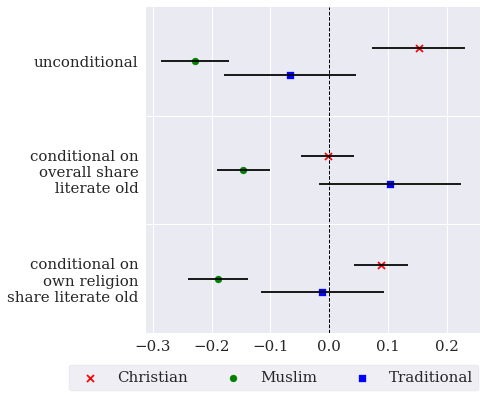

In [5]:
df = dfall[(dfall.weighted == 'unweighted') & 
           (dfall.fe == 'country') & 
           (dfall.direction == 'up')].copy(deep=True)

cp = CoefPlot(df)
f = cp.grouped_dotplot('b', 'major_religion', 'share_lit_old', err='err_t', figsize=(6,6), 
                        order_groups_by_variable='ordr',
                        within_group_order=['Christian', 'Muslim', 'Traditional'],
                        zero_line=True, group_separators=True,
                        legend=True, legend_bbox=(-0.25,-0.2), legend_columns=3)

In [6]:
for w in ['weighted', 'unweighted']:
    for fe in ['country', 'province']:
        for updn in ['up', 'down']:
            
            df = dfall[(dfall.weighted == w) & 
                       (dfall.fe == fe) & 
                       (dfall.direction == updn)].copy(deep=True)

            cp = CoefPlot(df)
            f = cp.grouped_dotplot('b', 'major_religion', 'share_lit_old', err='err_t', figsize=(6,6), 
                                    order_groups_by_variable='ordr',
                                    within_group_order=['Christian', 'Muslim', 'Traditional'],
                                    zero_line=True, group_separators=True,
                                    legend=True, legend_bbox=(-0.25,-0.2), legend_columns=3)
            
            f.savefig('{}/_8a_distlevel_im_relshare_{}_{}fe_{}.pdf'.format(outdir, w, fe, updn), bbox_inches='tight', dpi=100)
            plt.close(f)

# Scatter plots

The data for these comes from the output of `_16_run_distlevel_im_relshare_regressions.R`

- here we control for the OVERALL literacy of the old in the district (across all religions)

## christian and muslim IM levels on shares (both residualized)

### Controlling for lit old

In [7]:
df = pd.read_csv(os.path.join(wdir, '_distlevel_im_relshare_regressions_residuals_for_scatter_cm_level.csv'))
df

,xc,yc,xm,ym
0,-0.273740,-0.202977,0.375971,-0.211704
1,-0.288464,-0.187637,0.519913,-0.244659
2,-0.265196,-0.264948,0.529204,-0.167370
3,-0.410760,0.027872,0.673586,-0.268027
4,-0.405379,0.272384,0.685022,-0.217123
...,...,...,...,...
2173,0.059413,-0.000914,NaN,NaN
2174,0.000672,-0.008279,NaN,NaN
2175,-0.027305,-0.040175,NaN,NaN
2176,-0.015495,-0.049490,NaN,NaN


In [8]:
xlims = [(-0.4, 0.3), (-0.3, 0.5)]
ylims = [(-0.04, 0.035), (-0.1, 0.075)]
for imr, mr in enumerate(['c', 'm']):
    dfr = df[[f'x{mr}', f'y{mr}']].dropna()
    
    #####################################################
    # unweighted
    #####################################################
    m = OLS()
    m.fit(dfr[[f'x{mr}']], dfr[f'y{mr}'])
    
    f, ax = plt.subplots(1,1, figsize=(10, 6))
    ax = sns.regplot(x=dfr[f'x{mr}'], y=dfr[f'y{mr}'], ax=ax, x_bins=15, x_ci=None)
    ax.set_xlabel('district population share (residual)', size=15)
    ax.set_ylabel('upward IM (residual)', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlim(xlims[imr])
    ax.set_ylim(ylims[imr])

    if m.coef_[0] < 0:
        slope = ' - ' + f'{m.coef_[0]:.2f}'[1:]
    else:
        slope = f' + {m.coef_[0]:.2f}'
    text = 'IM$^{up}$ = $\\alpha_c$%s$\\times$ pop share' % slope
    ax.annotate(text, xy=(0.0, 1.05), xycoords='axes fraction', fontsize=15,
                horizontalalignment='left', verticalalignment='top')      
    
    f.savefig('{}/_8b_distlevel_im_relshare_illustration_binscatter_{}_unweighted.pdf'.format(outdir, mr), bbox_inches='tight', dpi=100)
    plt.close(f)

### not controlling for lit old

In [9]:
df = pd.read_csv(os.path.join(wdir, '_distlevel_im_relshare_regressions_residuals_for_scatter_cm_level_no_litcontrol.csv'))
df

,xc,yc,xm,ym
0,-0.304235,-0.238846,0.398559,-0.248779
1,-0.317985,-0.222360,0.541779,-0.280550
2,-0.291782,-0.296219,0.548897,-0.199693
3,-0.448682,-0.016732,0.701675,-0.314131
4,-0.433451,0.239365,0.705815,-0.251252
...,...,...,...,...
2173,0.022715,-0.044078,NaN,NaN
2174,-0.064829,-0.085322,NaN,NaN
2175,0.017047,0.011992,NaN,NaN
2176,-0.074787,-0.119229,NaN,NaN


In [10]:
xlims = [(-0.4, 0.3), (-0.3, 0.5)]
ylims = [(-0.09, 0.07), (-0.12, 0.13)]
for imr, mr in enumerate(['c', 'm']):
    dfr = df[[f'x{mr}', f'y{mr}']].dropna()
    
    #####################################################
    # unweighted
    #####################################################
    m = OLS()
    m.fit(dfr[[f'x{mr}']], dfr[f'y{mr}'])
    
    f, ax = plt.subplots(1,1, figsize=(10, 6))
    ax = sns.regplot(x=dfr[f'x{mr}'], y=dfr[f'y{mr}'], ax=ax, x_bins=15, x_ci=None)
    ax.set_xlabel('district population share (residual)', size=15)
    ax.set_ylabel('upward IM (residual)', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlim(xlims[imr])
    ax.set_ylim(ylims[imr])

    if m.coef_[0] < 0:
        slope = ' - ' + f'{m.coef_[0]:.2f}'[1:]
    else:
        slope = f' + {m.coef_[0]:.2f}'
    text = 'IM$^{up}$ = $\\alpha_c$%s$\\times$ pop share' % slope
    ax.annotate(text, xy=(0.0, 1.05), xycoords='axes fraction', fontsize=15,
                horizontalalignment='left', verticalalignment='top')      
    
    f.savefig('{}/_8b_distlevel_im_relshare_illustration_binscatter_{}_unweighted_no_litcontrol.pdf'.format(outdir, mr), bbox_inches='tight', dpi=100)
    plt.close(f)

## gaps

### controlling for litold

In [11]:
df = pd.read_csv(os.path.join(wdir, '_distlevel_im_relshare_regressions_residuals_for_scatter_cm_gap.csv'))
df

,xov,yov,xre,yre
0,0.376811,0.009309,0.375557,0.007254
1,0.520726,0.057586,0.524290,0.059951
2,0.529936,-0.097071,0.531881,-0.095155
3,0.674630,0.296622,0.656210,0.277450
4,0.685794,0.490042,0.627060,0.439185
...,...,...,...,...
1881,0.064761,-0.032306,-0.040847,-0.062751
1882,-0.048680,0.400380,0.041390,0.426115
1883,-0.042523,0.404577,-0.129448,0.379734
1884,-0.048472,-0.580728,-0.015933,-0.572236


In [12]:
xlims = [(-0.3, 0.5), (-0.3, 0.5)]
ylims = [(-0.065, 0.065), (-0.06, 0.06)]
for ilc, litcontrol in enumerate(['ov', 're']):
    dfr = df[[f'x{litcontrol}', f'y{litcontrol}']].dropna()
    
    #####################################################
    # unweighted
    #####################################################
    m = OLS()
    m.fit(dfr[[f'x{litcontrol}']], dfr[f'y{litcontrol}'])
    
    f, ax = plt.subplots(1,1, figsize=(10, 6))
    ax = sns.regplot(x=dfr[f'x{litcontrol}'], y=dfr[f'y{litcontrol}'], ax=ax, x_bins=15, x_ci=None)
    ax.set_xlabel('district population share (residual)', size=15)
    ax.set_ylabel('Christian - Muslim upward IM gap (residual)', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlim(xlims[ilc])
    ax.set_ylim(ylims[ilc])
    
    if m.coef_[0] < 0:
        slope = ' - ' + f'{m.coef_[0]:.2f}'[1:]
    else:
        slope = f' + {m.coef_[0]:.2f}'
    text = 'IM-Gap$^{up}$ = $\\alpha_c$%s$\\times$ Muslim pop share' % slope
    ax.annotate(text, xy=(0.0, 1.05), xycoords='axes fraction', fontsize=15,
                horizontalalignment='left', verticalalignment='top')      
    
    f.savefig('{}/_8b_distlevel_imgapcm_relshare_illustration_binscatter_{}_unweighted.pdf'.format(outdir, litcontrol),
              bbox_inches='tight', dpi=100)
    plt.close(f)

### not controlling for litold

In [13]:
df = pd.read_csv(os.path.join(wdir, '_distlevel_im_relshare_regressions_residuals_for_scatter_cm_gap_no_litcontrol.csv'))
df

,x,y
0,0.398559,0.009933
1,0.541779,0.058190
2,0.548897,-0.096527
3,0.701675,0.297399
4,0.705815,0.490617
...,...,...
1881,-0.002365,-0.034233
1882,-0.002311,0.401712
1883,-0.003251,0.405704
1884,-0.002506,-0.579408


In [14]:
xlims = [(-0.35, 0.55)]
ylims = [(-0.07, 0.07)]
dfr = df[['x', 'y']].dropna()

#####################################################
# unweighted
#####################################################
m = OLS()
m.fit(dfr[['x']], dfr['y'])

f, ax = plt.subplots(1,1, figsize=(10, 6))
ax = sns.regplot(x=dfr['x'], y=dfr['y'], ax=ax, x_bins=15, x_ci=None)
ax.set_xlabel('district population share (residual)', size=15)
ax.set_ylabel('Christian - Muslim upward IM gap (residual)', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim(xlims[0])
ax.set_ylim(ylims[0])

if m.coef_[0] < 0:
    slope = ' - ' + f'{m.coef_[0]:.2f}'[1:]
else:
    slope = f' + {m.coef_[0]:.2f}'
text = 'IM-Gap$^{up}$ = $\\alpha_c$%s$\\times$ Muslim pop share' % slope
ax.annotate(text, xy=(0.0, 1.05), xycoords='axes fraction', fontsize=15,
            horizontalalignment='left', verticalalignment='top')      

f.savefig('{}/_8b_distlevel_imgapcm_relshare_illustration_binscatter_unweighted_no_litcontrol.pdf'.format(outdir),
          bbox_inches='tight', dpi=100)
plt.close(f)